In [2]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [3]:
dim=(54, 4100, 1704)
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b  
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>=0 and lag<n
    if lag==0: return arr.copy()
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba    
def s_forward(arr,step=1):
    l,m,n=arr.shape
    assert step>0 and step<n
    a=arr[:,:,step:]
    b=np.empty(shape=[l,m,step],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([a,b],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

In [4]:
cat_lag_features={
 "city_0",
  "class_0",
  "cluster_0",
  "family_0",
  "state_0",
  "type_0",

 'city_mv36',
 'class_mv36',
 'cluster_mv36',
 'family_mv36',
 'state_mv36',
 'type_mv36',    
 
 'item_mean_0',
 'store_mean_0',
 }
cat_features={
 'holiday_0',
 'onpromotionraw_0',
 'wage_0',
 'd900'
 }
oil_features={'oil_0', 'oil_d1', 'oil_d10', 'oil_d15', 'oil_d3', 'oil_d5'}
sales_ma_features={'sales_ma_112',
 'sales_ma_14',
 'sales_ma_224',
 'sales_ma_28',
 'sales_ma_3',
 'sales_ma_56',
 'sales_ma_7'}
sales_season_ma_features={'sales_week_season_ma_p13',
 'sales_week_season_ma_p2',
 'sales_week_season_ma_p3',
 'sales_week_season_ma_p4',
 'sales_week_season_ma_p7'}

#move x, fix y
def _get_feature(name,lag=0,offset=0):
    if name in cat_lag_features :
        assert lag == 0
        if name in ['item_mean_0','class_mv36','family_mv36','class_0','family_0']:
            s=get_series2(name)
        else:
            s=get_series(name)
        return s_lag(s,offset)
    if name in cat_features or name in oil_features:
        assert offset==0 and lag==0
        s= get_series(name)
        if name =='holiday_0': s[np.isnan(s)]=0
        return s
    if name =="y_0" or name in sales_ma_features or name in sales_season_ma_features:
        #assert  lag == 0
        s=get_series(name)
        if offset==0 and lag==0: return s
        return s_lag(s,lag=offset+lag)
def get_feature(name,lag=0,offset=0):
    s=_get_feature(name=name,lag=lag,offset=offset)
    if s.shape == ( 4100,54, 1704):
        s=np.rollaxis(s,1,0)
    assert s.shape==(54, 4100, 1704), s.shape
    return s
def get_all_features(offset=1):
    assert offset==0
    lag_features=[]
    ondate_features=[]
    for name in cat_lag_features:
        lag_features.append({"name":name,"lag":0,"offset":offset})
    for name in cat_features:
        ondate_features.append({"name":name,"lag":0,"offset":0})   
    for i in range(0,1):
        lag_features.append({"name":"y_0","lag":i ,"offset":offset})  
    for name in sales_ma_features:
        lag_features.append({"name":name,"lag":0,"offset":offset})  
    for name in sales_season_ma_features:
        lag_features.append({"name":name,"lag":(700-offset)%7,"offset":offset})
    return lag_features,ondate_features    
def calc_feature(feat):
    return get_feature(**feat)
def col_name(feat):
    return "{}-lag{}-offset{}".format(feat['name'],feat['lag'],feat['offset'])
def get_train_test():
    lag_features,ondate_features=get_all_features(0)    
    
    print "\n For lag features", str(list(lag_features))
    lag_cols=[]
    lag_train_lst=[]
    for feat in lag_features:
        col=col_name(feat)
        print col,
        arr=calc_feature(feat).astype(np.float16)
        lag_train_lst.append(arr)
        lag_cols.append(col)
        gc.collect()
    print "\n For on_date features", str(list(ondate_features))
    ondate_cols=[]
    ondate_train_lst=[]
    for feat in ondate_features:
        col=col_name(feat)
        print col,
        arr=calc_feature(feat).astype(np.float16)
        ondate_train_lst.append(arr)
        ondate_cols.append(col)
        gc.collect()

    return np.array(lag_cols),  np.array(lag_train_lst,copy=False), np.array(ondate_cols),np.array(ondate_train_lst,copy=False)

In [5]:
def read_data():
    print "read data for day" 
    y=get_series('y_0')
    lag_cols,lag_train_test,ondate_cols,ondate_train_test=get_train_test()
    lag_train_test=np.rollaxis(lag_train_test,0,4)
    ondate_train_test=np.rollaxis(ondate_train_test,0,4)
    print "loaded", y.shape,lag_train_test.shape,ondate_train_test.shape 
    return lag_cols,ondate_cols,lag_train_test,ondate_train_test,y.astype(np.float16)

In [6]:
%time lag_cols,ondate_cols,lag_train_test,ondate_train_test,rawy=read_data()
#rawy=y 
proby=(rawy>0).astype(np.float16)
#y[np.isnan(y)]=0

read data for day

 For lag features [{'lag': 0, 'name': 'store_mean_0', 'offset': 0}, {'lag': 0, 'name': 'family_0', 'offset': 0}, {'lag': 0, 'name': 'city_0', 'offset': 0}, {'lag': 0, 'name': 'cluster_mv36', 'offset': 0}, {'lag': 0, 'name': 'cluster_0', 'offset': 0}, {'lag': 0, 'name': 'city_mv36', 'offset': 0}, {'lag': 0, 'name': 'item_mean_0', 'offset': 0}, {'lag': 0, 'name': 'class_0', 'offset': 0}, {'lag': 0, 'name': 'type_0', 'offset': 0}, {'lag': 0, 'name': 'type_mv36', 'offset': 0}, {'lag': 0, 'name': 'state_mv36', 'offset': 0}, {'lag': 0, 'name': 'class_mv36', 'offset': 0}, {'lag': 0, 'name': 'state_0', 'offset': 0}, {'lag': 0, 'name': 'family_mv36', 'offset': 0}, {'lag': 0, 'name': 'y_0', 'offset': 0}, {'lag': 0, 'name': 'sales_ma_224', 'offset': 0}, {'lag': 0, 'name': 'sales_ma_14', 'offset': 0}, {'lag': 0, 'name': 'sales_ma_28', 'offset': 0}, {'lag': 0, 'name': 'sales_ma_112', 'offset': 0}, {'lag': 0, 'name': 'sales_ma_7', 'offset': 0}, {'lag': 0, 'name': 'sales_ma_3', 'of

In [7]:
print "types", [u.dtype for u in (lag_cols, lag_train_test,ondate_train_test, rawy,proby)]
print "shapes", [u.shape for u in (lag_cols, lag_train_test,ondate_train_test, rawy,proby)]
print "mem(gb)",np.round(lag_train_test.nbytes/1024.**3,2),np.round(ondate_train_test.nbytes/1024.**3,2), np.round(rawy.nbytes/1024.**3,2)

types [dtype('S37'), dtype('float16'), dtype('float16'), dtype('float16'), dtype('float16')]
shapes [(27,), (54, 4100, 1704, 27), (54, 4100, 1704, 4), (54, 4100, 1704), (54, 4100, 1704)]
mem(gb) 18.97 2.81 0.7


In [8]:
gc.collect()

0

In [9]:
def show_data(store,item,date,filters=None):
    idx_range=np.array(range(date-6,date+3))
    thisy=rawy[store,item,idx_range]
    thisproby=proby[store,item,idx_range]
    
    a=np.squeeze(lag_train_test[store,item,idx_range,:])
    b=np.squeeze(ondate_train_test[store,item,idx_range,:])
    ab=np.concatenate([a,b],axis=1)
    print ab.shape
    columns=list(lag_cols)+list(ondate_cols)
    if filters is not None: 
        filtered_columns = [u for u in columns if filters(u)]
    df=pd.DataFrame(ab,columns=columns,index=idx_range)[filtered_columns]
    df['target_y']=thisy
    df['target_proby']=thisproby
    with pd.option_context('display.max_columns', None):
        display(df)

In [10]:
#show_data(0,1000,1688, None)#lambda u: 'y_0' in u)
show_data(0,1000,1688, lambda u: 'y_0' in u)

(9, 31)


family_0-lag0-offset0  city_0-lag0-offset0  y_0-lag0-offset0  \
1682               1.627930             1.714844          2.773438   
1683               1.722656             1.834961          2.638672   
1684               1.694336             1.823242          0.693359   
1685               1.751953             1.890625          0.693359   
1686               1.664062             1.812500          1.946289   
1687               1.662109             1.800781          1.098633   
1688                    NaN                  NaN               NaN   
1689                    NaN                  NaN               NaN   
1690                    NaN                  NaN               NaN   

      holiday_0-lag0-offset0  target_y  target_proby  
1682                     1.0  2.773438           1.0  
1683                     1.0  2.638672           1.0  
1684                     0.0  0.693359           1.0  
1685                     0.0  0.693359           1.0  
1686                     0.0  1.946289           1.0  
1687                     0.0  1.098633           1.0  
1688                     0.0       NaN           0.0  
1689                     0.0       NaN           0.0  
1690                     0.0       NaN           0.0

In [11]:
def show_data2():
    lst=[]
    days=range(1685,1691)
    for train_test,cols in [(lag_train_test,lag_cols),(ondate_train_test,ondate_cols)]:
        for i in range(len(cols)):
            print i,
            lst.append(cols[i])
            #for i in range(train_test.shape[-1]):
            if 1:
                for d in days:
                    u=train_test[:,:,d,i]
                    lst.append(np.round(np.isnan(u).mean(),4))
                #break
    print len(lst)
    df=pd.DataFrame(np.array(lst).reshape([-1,len(days)+1]) ,columns=['col']+days)
    return df

In [12]:
lag_train_test.shape

(54, 4100, 1704, 27)

In [13]:
show_data2()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 0 1 2 3 217


col    1685    1686    1687    1688  \
0               store_mean_0-lag0-offset0     0.0     0.0     0.0     1.0   
1                   family_0-lag0-offset0     0.0  0.0002  0.0002     1.0   
2                     city_0-lag0-offset0     0.0     0.0     0.0     1.0   
3               cluster_mv36-lag0-offset0     0.0     0.0     0.0     0.0   
4                  cluster_0-lag0-offset0     0.0     0.0     0.0     1.0   
5                  city_mv36-lag0-offset0     0.0     0.0     0.0     0.0   
6                item_mean_0-lag0-offset0  0.0798  0.0824  0.0802     1.0   
7                    class_0-lag0-offset0  0.0068  0.0073  0.0073     1.0   
8                     type_0-lag0-offset0     0.0     0.0     0.0     1.0   
9                  type_mv36-lag0-offset0     0.0     0.0     0.0     0.0   
10                state_mv36-lag0-offset0     0.0     0.0     0.0     0.0   
11                class_mv36-lag0-offset0  0.0083  0.0083  0.0083  0.0083   
12                   state_0-lag0-offset0     0.0     0.0     0.0     1.0   
13               family_mv36-lag0-offset0     0.0     0.0     0.0     0.0   
14                       y_0-lag0-offset0  0.5208  0.5359  0.5356     1.0   
15              sales_ma_224-lag0-offset0  0.4986  0.4985  0.4984  0.4996   
16               sales_ma_14-lag0-offset0  0.5118  0.5132   0.516  0.5365   
17               sales_ma_28-lag0-offset0  0.5039  0.5041  0.5038  0.5124   
18              sales_ma_112-lag0-offset0  0.4901  0.4905  0.4904  0.4926   
19                sales_ma_7-lag0-offset0  0.5128  0.5133  0.5118  0.5472   
20                sales_ma_3-lag0-offset0  0.5104  0.5127  0.5173  0.6162   
21               sales_ma_56-lag0-offset0  0.4961  0.4962   0.496  0.5002   
22   sales_week_season_ma_p7-lag0-offset0     0.0     0.0     0.0     0.0   
23   sales_week_season_ma_p4-lag0-offset0     0.0     0.0     0.0     0.0   
24  sales_week_season_ma_p13-lag0-offset0     0.0     0.0     0.0     0.0   
25   sales_week_season_ma_p2-lag0-offset0  0.5208  0.5359  0.5356     1.0   
26   sales_week_season_ma_p3-lag0-offset0     0.0     0.0     0.0     0.0   
27                 holiday_0-lag0-offset0     0.0     0.0     0.0     0.0   
28                      d900-lag0-offset0     0.0     0.0     0.0     0.0   
29          onpromotionraw_0-lag0-offset0  0.5208  0.5359  0.5356  0.0485   
30                    wage_0-lag0-offset0     0.0     0.0     0.0     0.0   

      1689    1690  
0      1.0     1.0  
1      1.0     1.0  
2      1.0     1.0  
3      0.0     0.0  
4      1.0     1.0  
5      0.0     0.0  
6      1.0     1.0  
7      1.0     1.0  
8      1.0     1.0  
9      0.0     0.0  
10     0.0     0.0  
11  0.0083  0.0083  
12     1.0     1.0  
13     0.0     0.0  
14     1.0     1.0  
15  0.5007  0.5018  
16  0.5599  0.5895  
17  0.5215  0.5317  
18  0.4947   0.497  
19  0.5971  0.6915  
20     1.0     1.0  
21  0.5043  0.5089  
22     0.0     0.0  
23     0.0     0.0  
24     0.0     0.0  
25     1.0     1.0  
26     0.0     0.0  
27     0.0     0.0  
28     0.0     0.0  
29  0.0485  0.0485  
30     0.0     0.0

# cv

In [14]:
class IndexIterator():
    def __init__(self,index):
        self.index=index
        self.N=len(self.index)
        self.shuffle()
        self.pos=0
    def shuffle(self):
        np.random.shuffle(self.index)
        
    def next(self):
        if self.pos>=self.N:
            self.pos=0
            self.shuffle()
        r=self.index[self.pos]
        self.pos+=1
        return r
    
class DataGen():
    def __init__(self,lag_X,ondate_X, rawy, proby, low,high,lookback1=14,
                 lookback2=21,lookforward=16,batchsize=4096,valid_split=0.0):
        assert valid_split>=0 and valid_split<1
        assert low>=lookback1
        assert low>=lookback2        
        self.lookback1=lookback1
        self.lookback2=lookback2    
        self.lookforward=lookforward
        self.batchsize=batchsize
        a,b,c=rawy.shape
        assert high+lookforward <=c 
        assert len(lag_X)==len(rawy)
        assert lag_X.shape[:3]==ondate_X.shape[:3]
        assert rawy.shape==proby.shape
        self._shape=(a,b,high-low)
        self.lag_X=lag_X
        self.ondate_X=ondate_X
        self.mask=np.ones_like(rawy)
        self.mask[:,:,1688:]=0
        self.rawy=rawy
        self.proby=proby        
        self.low=low
        self.high=high

        N=a*b*(high-low)
        if valid_split==0:
            self.train_iterator=IndexIterator(np.array(range(N)))
            print "train has {} records out of {} records".format(self.train_iterator.N,np.prod(self._shape))
            self.valid_iterator=None
        else:
            indexes=np.array(range(self.N))
            np.random.shuffle(indexes)
            train_N=int(1.0*valid_split*N)
            self.train_iterator=IndexIterator(indexes[:train_N])
            self.valid_iterator=IndexIterator(indexes[train_N:])
            print "train has {} records out of {} records".format(self.train_iterator.N,np.prod(self._shape))
            print "valid has {} records out of {} records".format(self.valid_iterator.N,np.prod(self._shape))
            
    @property
    def train_steps_per_epoch(self):
        return int(self.train_iterator.N/self.batchsize)
    @property
    def valid_steps_per_epoch(self):
        return int(self.valid_iterator.N/self.batchsize)    
    
    def support_valid(self):
        return self.valid_iterator is not None
    
    def idx_to_cord(self,idxes):
        _,b,c=self._shape
        z=idxes%c+self.low
        xy=idxes//c
        y=xy%b
        x=xy//b
        return x,y,z
    def slice(self,cord_x,cord_y,cord_z):
        #assert cord_z-self.lookback>=0
        lag_arr=self.lag_X[cord_x,cord_y, (cord_z-self.lookback1):cord_z] #on non zero target lstm
        ondate_arr=self.ondate_X[cord_x,cord_y, cord_z: (cord_z+self.lookforward)] # on non zero target fc
        proby_arr=self.proby[cord_x,cord_y, (cord_z-self.lookback2):cord_z] # on prob lstm
        target_y=self.rawy[cord_x,cord_y, cord_z: (cord_z+self.lookforward)]         # output 
        mask_y=self.mask[cord_x,cord_y, cord_z: (cord_z+self.lookforward)]        
        
        assert (ondate_arr.shape[0]==self.lookforward) & (lag_arr.shape[0]==self.lookback1) \
            & (proby_arr.shape[0]==self.lookback2) & (target_y.shape[0]==self.lookforward)
        return   lag_arr,  ondate_arr,   proby_arr , target_y, mask_y

    def next_batch(self,iterator):
        lag_arr=[]; ondate_arr=[]; proby_arr=[]; target_y=[]; mask_y=[]
        while len(lag_arr)<self.batchsize:
            num=iterator.next()
            a,b,c,d,e=self.__getitem__(num)
            lag_arr.append(a)
            ondate_arr.append(b)
            proby_arr.append(c)
            target_y.append(d)
            mask_y.append(e)
        target=np.array(target_y,copy=False).astype(np.float32,copy=False)
        return {'lagx': np.array(lag_arr,copy=False).astype(np.float32,copy=False), 
                'ondatex': np.array(ondate_arr,copy=False).astype(np.float32,copy=False), 
                'probx': np.array(proby_arr,copy=False).astype(np.float32,copy=False),
                'masky':np.array(mask_y,copy=False).astype(np.float32,copy=False)
               }, [target,target,target]
    
    def next_train_batch(self):
        while 1:
            yield self.next_batch(self.train_iterator)
    
    def next_valid_batch(self):
        while 1:
            yield self.next_batch(self.valid_iterator)
       
    def __getitem__(self, num):
        crod_x,cord_y,cord_z=self.idx_to_cord(num)
        return self.slice(crod_x,cord_y,cord_z)
    def get_by_t(self,store,item,day):
        return self.slice(store,item,day)
    def get_by_t2(self,day):
        lag_arr=[]; ondate_arr=[]; proby_arr=[]; target_y=[]
        m,n,_=self._shape
        indexes=[]
        for i in range(m):
            for j in range(n):
                a,b,c,d=self.get_by_t(i,j,day)
                lag_arr.append(a)
                ondate_arr.append(b)
                proby_arr.append(c)
                target_y.append(d)
                indexes.append((i,j))
        return {'lagx': np.array(lag_arr).astype(np.float32), 
                'ondatex': np.array(ondate_arr).astype(np.float32), 
                'probx': np.array(proby_arr).astype(np.float32),
                'masky':np.array(mask_y,copy=False).astype(np.float32,copy=False)
               }, np.array(target_y).astype(np.float32), np.array(indexes)


In [15]:
n_reg_lookback=14
n_clf_lookback=21
n_lookforward=1

In [16]:
if 1:
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy, proby,100,1628, lookback1=n_reg_lookback, lookback2=n_clf_lookback,lookforward=n_lookforward)
    valid_gen=DataGen(lag_train_test,ondate_train_test,rawy, proby,1628,1668, lookback1=n_reg_lookback, lookback2=n_clf_lookback,lookforward=n_lookforward)
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy, proby,1668,1688, lookback1=n_reg_lookback, lookback2=n_clf_lookback,lookforward=n_lookforward)
else:    
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy, proby,100,1688, lookback1=n_reg_lookback, lookback2=n_clf_lookback,lookforward=n_lookforward)
    valid_gen=None,None

train has 338299200 records out of 338299200 records
train has 8856000 records out of 8856000 records
train has 4428000 records out of 4428000 records


In [17]:
train_gen.train_steps_per_epoch,\
valid_gen.train_steps_per_epoch

(82592, 2162)

In [18]:
def show_record(datagen, store,item,day,filter_fn=None):
    lag_arr,  ondate_arr,   proby_arr , target_y,_=datagen.get_by_t(store,item,day)
    df1=pd.DataFrame(ondate_arr,columns=ondate_cols,index=range(day,day+len(ondate_arr)))
    df1['target_y_0']=target_y
    #display(df1)
    df2=pd.DataFrame(lag_arr,columns=lag_cols,index=range(day-len(lag_arr),day))
    #display(df2)
    df3=pd.DataFrame(proby_arr,columns=['lag_y_0_proby'],index=range(day-len(proby_arr),day))
    #display(df3)  
    idx=sorted(set(list(df1.index)+list(df2.index)+list(df3.index)))
    df=pd.concat([df1,df2,df3],axis=1).loc[idx]
    df['raw_y_0']=rawy[store,item][df.index]
    if filter_fn:
        df=df[[u for u in df.columns if filter_fn(u)]]
    with pd.option_context('display.max_columns', None):
        display(df)  


In [19]:
show_record(test_gen,0,100,1687,filter_fn=lambda u: 'y_0' in u)

holiday_0-lag0-offset0  target_y_0  family_0-lag0-offset0  \
1666                     NaN         NaN                    NaN   
1667                     NaN         NaN                    NaN   
1668                     NaN         NaN                    NaN   
1669                     NaN         NaN                    NaN   
1670                     NaN         NaN                    NaN   
1671                     NaN         NaN                    NaN   
1672                     NaN         NaN                    NaN   
1673                     NaN         NaN               1.780273   
1674                     NaN         NaN               1.749023   
1675                     NaN         NaN               1.663086   
1676                     NaN         NaN               1.717773   
1677                     NaN         NaN               1.821289   
1678                     NaN         NaN               1.866211   
1679                     NaN         NaN               1.696289   
1680                     NaN         NaN               1.639648   
1681                     NaN         NaN               1.627930   
1682                     NaN         NaN               1.627930   
1683                     NaN         NaN               1.722656   
1684                     NaN         NaN               1.694336   
1685                     NaN         NaN               1.751953   
1686                     NaN         NaN               1.664062   
1687                     0.0         NaN                    NaN   

      city_0-lag0-offset0  y_0-lag0-offset0  lag_y_0_proby   raw_y_0  
1666                  NaN               NaN            1.0  1.098633  
1667                  NaN               NaN            1.0  0.693359  
1668                  NaN               NaN            1.0  0.693359  
1669                  NaN               NaN            1.0  1.098633  
1670                  NaN               NaN            0.0       NaN  
1671                  NaN               NaN            0.0       NaN  
1672                  NaN               NaN            1.0  0.693359  
1673             1.948242          0.693359            1.0  0.693359  
1674             1.941406               NaN            0.0       NaN  
1675             1.794922               NaN            0.0       NaN  
1676             1.867188          1.386719            1.0  1.386719  
1677             1.977539          1.098633            1.0  1.098633  
1678             2.031250          1.386719            1.0  1.386719  
1679             1.849609          0.693359            1.0  0.693359  
1680             1.785156          1.386719            1.0  1.386719  
1681             1.789062          1.098633            1.0  1.098633  
1682             1.714844          0.693359            1.0  0.693359  
1683             1.834961          1.098633            1.0  1.098633  
1684             1.823242               NaN            0.0       NaN  
1685             1.890625               NaN            0.0       NaN  
1686             1.812500               NaN            0.0       NaN  
1687                  NaN               NaN            NaN       NaN

In [20]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [21]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [22]:
print K.floatx()

float32


In [23]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [24]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim

(27, 4)

In [25]:
class TransformNALayer(Layer):

    def __init__(self, n_input,  **kwargs):
        super(TransformNALayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.n_input=n_input
    def build(self, input_shape):
        super(TransformNALayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x,training=None):
        def make_na(x):
            ind=tf.is_nan(x)
            filled_x=tf.where(ind, tf.zeros_like(x,dtype=np.float32), x)
            ind=tf.cast(ind,tf.float32)
            filled_x=tf.cast(filled_x,tf.float32)
            return  tf.cast(tf.concat([filled_x,ind],axis=-1),tf.float32)
        def add_dropout(x):
            def f(x):
                ind=tf.random_uniform([1,self.n_input])<tf.random_uniform([1])[0]/tf.constant(5.0)
                ind2=tf.cast(ind,tf.float32)*tf.ones_like(x)
                newx=tf.where(ind2>0,tf.constant(np.nan,dtype=tf.float32)*tf.ones_like(x), x)
                return newx
            return tf.cond(tf.random_uniform([1])[0]>tf.constant(0.5),lambda: f(x),lambda : x)
        return K.in_train_phase(make_na(add_dropout(x)),make_na(x),training=training)
        #return make_na(x)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1],input_shape[2]*2)        

In [26]:
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 1.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print "set learning rate to",lrate
   return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [27]:
#plt.plot([step_decay(u) for u in range(5)])

In [28]:
from keras.layers import Input, CuDNNLSTM,RepeatVector, Concatenate,TimeDistributed, Lambda
from keras import Model

In [29]:
def get_NA_MSE_ERROR(mask_y):
    def NA_MSE_ERROR(y_true, y_pred):
        ind=(tf.constant(1,dtype=tf.float32)-tf.cast( tf.is_nan(y_true),tf.float32))*mask_y
        new_y_true=tf.where(tf.is_nan(y_true),y_pred,y_true)
        d2=K.square(y_pred - new_y_true)
        return K.sum(d2*ind)/(K.sum(ind)+1e-7)
    return NA_MSE_ERROR
def get_MSE_ERROR(mask_y):
    def MSE_ERROR(y_true, y_pred):
        new_y_true=tf.where(tf.is_nan(y_true),tf.zeros_like(y_true),y_true)
        d2=K.square(y_pred - new_y_true)
        return K.sum(d2*mask_y)/(K.sum(mask_y)+1e-7)
    return MSE_ERROR
def get_BINARY_ERROR(mask_y):
    def BINARY_ERROR(y_true, y_pred):
        #new_y_true=tf.where(tf.is_nan(y_true),tf.zeros_like(y_true),y_true)
        new_y_true=tf.cast(y_true>0, tf.float32)
        s=new_y_true*tf.log(y_pred+1e-7)+(1-new_y_true)*tf.log(1-y_pred+1e-7)
        return -K.sum(s*mask_y)/(K.sum(mask_y)+1e-7)
    return BINARY_ERROR

In [30]:
(n_lookforward,ondate_input_dim)

(1, 4)

In [37]:
class WeightsCallback(keras.callbacks.Callback):
    def __init__(self, obj):
        self.obj=obj
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:
            self.obj.alpha.set_value(1.0)
            self.obj.beta.set_value(0.0)
            self.obj.gamma.set_value(0.0)
        print("epoch %s, alpha = %s, beta = %s, gamma=%s" % (epoch, K.get_value(self.obj.alpha), 
                                                   K.get_value(self.obj.beta), K.get_value(self.obj.gamma)))

class KerasModel:
    def __init__(self,params={}):
        self.params=params
        self.model=None
        
    def _build_reg_model(self):
        params=self.params
        input_ondate = Input(shape=(n_lookforward,ondate_input_dim),name='ondatex')
        input_ondate_trans = TransformNALayer(ondate_input_dim)(input_ondate)

        input_x = Input(shape=(n_reg_lookback,lag_input_dim),name='lagx')
        input_x_trans = TransformNALayer(lag_input_dim)(input_x)

        if params['batch_normalization']:        
            input_x_trans=BatchNormalization(input_x_trans)
        encoded=CuDNNLSTM(256)(input_x_trans)
        encoded=RepeatVector(n_lookforward)(encoded)
        decoded=CuDNNLSTM(256,return_sequences=True)(encoded)
        merged = Concatenate()([input_ondate_trans,decoded])
        fc1=TimeDistributed(Dense(256,activation='relu'))(merged)
        fc2=TimeDistributed(Dense(1,activation='relu'))(fc1)
        output=Lambda(lambda u: K.squeeze(u,-1),name='reg')(fc2)
        return [input_ondate,input_x],output 
    def _build_clf_model(self):
        params=self.params
        input_x = Input(shape=(n_clf_lookback,),name='probx')
        encoded=Lambda(lambda u: K.expand_dims(u,-1))(input_x)
        encoded=CuDNNLSTM(256)(encoded)
        encoded=RepeatVector(n_lookforward)(encoded)
        decoded=CuDNNLSTM(256,return_sequences=True)(encoded)
        fc2=TimeDistributed(Dense(1,activation='sigmoid'))(decoded)
        output=Lambda(lambda u: K.squeeze(u,-1),name='clf')(fc2)
        
        return [input_x],output
    
    def _make_model(self):
        params=self.params
        mask_y = Input(shape=(n_lookforward,),name='masky')
        inputs1,reg_output=self._build_reg_model()
        inputs2, clf_output=self._build_clf_model()
        output=Lambda(lambda u: u[0]*u[1],name='total')( [reg_output,clf_output])
        inputs=[mask_y]+inputs1+inputs2
        outputs=[ output,reg_output,clf_output]
        model = Model(inputs=inputs,outputs=outputs)

        this_losses={'reg':get_NA_MSE_ERROR(mask_y),'total': get_MSE_ERROR(mask_y),'clf':get_BINARY_ERROR(mask_y)}

        #self.alpha = K.variable(0.0)
        #self.alpha = VariableInput().build((1,)).set_value(0.0)
        #self.beta = VariableInput().build((1,)).set_value(0.5)
        #self.gamma = VariableInput().build((1,)).set_value(0.5)
        
        #this_loss_weights={'reg':self.beta.var,'total': self.alpha.var,'clf':self.gamma.var}
        this_loss_weights={'reg':0.5,'total': 0.0,'clf':0.5}
        model.compile(optimizer=params['optimizer'],
                      loss=this_losses,
                      loss_weights=this_loss_weights,
                      metrics={'total':get_NA_MSE_ERROR(mask_y)})

        self.model=model
        return self
    def fit(self,traingen,validgen=None):
        params=self.params
        validation_split=params['validation_split']
        patience=params['patience']
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        #print "earlystopping on "+metric_name
        #self.name='day'+str(DAY)+'_adam.{epoch:02d}-{val_loss:.3f}.h5'
        self.name='all_days_adam.h5'

        early_stopping = EarlyStopping(monitor='val_total_loss', patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_total_loss', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     save_weights_only=False, 
                                                     mode='auto', period=1)        
        batch_size=params['batch_size']

        if validgen is not None:
            validation_data=validgen.next_train_batch()
            validation_steps=validgen.train_steps_per_epoch
        else:
            validation_data=traingen.next_valid_batch()
            validgen=traingen.valid_steps_per_epoch
        self.hist=self.model.fit_generator(traingen.next_train_batch(),
                                            steps_per_epoch=traingen.train_steps_per_epoch//100,
                                           validation_steps=validation_steps//10,
                                           epochs=200, 
                       validation_data=validation_data,
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return self
    def load_best(self):
        return keras.models.load_model(self.name,
                                       custom_objects={'TransformNALayer':TransformNALayer})
    

In [38]:
param_grid={
            'batch_size':[1024],
            'hidden_layer_sizes': [(256,256),()],
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "validation_split":[0.1],"patience":[3],
            "dropout_rate":[0.0],
            "activation":['relu'],    
            "l2":[1e-6,0],
            "epsilon":[0.1],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(12,
 {'activation': 'relu',
  'batch_normalization': False,
  'batch_size': 1024,
  'dropout_rate': 0.0,
  'epsilon': 0.1,
  'hidden_layer_sizes': (256, 256),
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3,
  'validation_split': 0.1})

In [39]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=KerasModel(parameter)
a._make_model()
a.params

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [40]:
if 0:
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    for l in a.model.layers:
        print l, l.input_shape 
    display(SVG(model_to_dot(a.model,show_shapes=True).create(prog='dot', format='svg')))
   

In [41]:
#a.model.summary()

In [42]:
a.fit(train_gen,valid_gen)

Epoch 1/200
825/825 [==============================] - 127s 154ms/step - loss: 0.2750 - total_loss: 0.2397 - reg_loss: 0.3369 - clf_loss: 0.2131 - total_NA_MSE_ERROR: 0.4619 - val_loss: 0.2834 - val_total_loss: 0.2777 - val_reg_loss: 0.2724 - val_clf_loss: 0.2944 - val_total_NA_MSE_ERROR: 0.3810
Epoch 2/200
825/825 [==============================] - 126s 153ms/step - loss: 0.2388 - total_loss: 0.2091 - reg_loss: 0.2772 - clf_loss: 0.2004 - total_NA_MSE_ERROR: 0.3894 - val_loss: 0.2764 - val_total_loss: 0.2737 - val_reg_loss: 0.2578 - val_clf_loss: 0.2950 - val_total_NA_MSE_ERROR: 0.3598
Epoch 3/200
825/825 [==============================] - 128s 155ms/step - loss: 0.2334 - total_loss: 0.2061 - reg_loss: 0.2674 - clf_loss: 0.1993 - total_NA_MSE_ERROR: 0.3803 - val_loss: 0.2784 - val_total_loss: 0.2693 - val_reg_loss: 0.2629 - val_clf_loss: 0.2938 - val_total_NA_MSE_ERROR: 0.3359
Epoch 4/200
825/825 [==============================] - 127s 153ms/step - loss: 0.2316 - total_loss: 0.2038 - 

<__main__.KerasModel instance at 0x7f708da9fb90>

In [36]:
a.fit(train_gen,valid_gen)

Epoch 1/200
825/825 [==============================] - 128s 155ms/step - loss: 0.2160 - total_loss: 0.1665 - reg_loss: 0.4137 - clf_loss: 8.9692 - total_NA_MSE_ERROR: 0.4169 - val_loss: 0.1859 - val_total_loss: 0.1606 - val_reg_loss: 0.2871 - val_clf_loss: 7.2673 - val_total_NA_MSE_ERROR: 0.2871
Epoch 2/200
825/825 [==============================] - 125s 151ms/step - loss: 0.1860 - total_loss: 0.1422 - reg_loss: 0.3610 - clf_loss: 9.1233 - total_NA_MSE_ERROR: 0.3610 - val_loss: 0.1841 - val_total_loss: 0.1570 - val_reg_loss: 0.2924 - val_clf_loss: 7.2054 - val_total_NA_MSE_ERROR: 0.2924
Epoch 3/200
825/825 [==============================] - 125s 152ms/step - loss: 0.1743 - total_loss: 0.1335 - reg_loss: 0.3375 - clf_loss: 9.0708 - total_NA_MSE_ERROR: 0.3375 - val_loss: 0.1604 - val_total_loss: 0.1349 - val_reg_loss: 0.2623 - val_clf_loss: 7.1369 - val_total_NA_MSE_ERROR: 0.2623
Epoch 4/200
825/825 [==============================] - 126s 152ms/step - loss: 0.1694 - total_loss: 0.1290 - 

KeyboardInterrupt: 

In [ ]:
a.fit(train_gen,valid_gen)

Epoch 1/200
825/825 [==============================] - 130s 157ms/step - loss: 0.2744 - total_loss: 0.2407 - reg_loss: 0.4092 - clf_loss: 7.5317 - total_NA_MSE_ERROR: 0.4130 - val_loss: 0.3053 - val_total_loss: 0.3019 - val_reg_loss: 0.3187 - val_clf_loss: 5.0191 - val_total_NA_MSE_ERROR: 0.3187
Epoch 2/200
825/825 [==============================] - 127s 154ms/step - loss: 0.2402 - total_loss: 0.2148 - reg_loss: 0.3416 - clf_loss: 2.0085 - total_NA_MSE_ERROR: 0.3620 - val_loss: 0.2865 - val_total_loss: 0.2803 - val_reg_loss: 0.3111 - val_clf_loss: 1.3938 - val_total_NA_MSE_ERROR: 0.3229
Epoch 3/200
825/825 [==============================] - 126s 152ms/step - loss: 0.2262 - total_loss: 0.2029 - reg_loss: 0.3193 - clf_loss: 1.7581 - total_NA_MSE_ERROR: 0.3395 - val_loss: 0.2821 - val_total_loss: 0.2763 - val_reg_loss: 0.3053 - val_clf_loss: 1.4265 - val_total_NA_MSE_ERROR: 0.3099
Epoch 4/200
825/825 [==============================] - 126s 153ms/step - loss: 0.2233 - total_loss: 0.2000 - 

In [43]:
a.fit(train_gen,valid_gen)

Epoch 1/200
825/825 [==============================] - 129s 157ms/step - loss: 0.2618 - total_loss: 0.2383 - reg_loss: 0.3560 - clf_loss: 0.4490 - total_NA_MSE_ERROR: 0.4398 - val_loss: 0.2814 - val_total_loss: 0.2832 - val_reg_loss: 0.2741 - val_clf_loss: 0.3069 - val_total_NA_MSE_ERROR: 0.3462
Epoch 2/200
825/825 [==============================] - 128s 155ms/step - loss: 0.2202 - total_loss: 0.2057 - reg_loss: 0.2784 - clf_loss: 0.2055 - total_NA_MSE_ERROR: 0.3727 - val_loss: 0.2760 - val_total_loss: 0.2760 - val_reg_loss: 0.2760 - val_clf_loss: 0.2986 - val_total_NA_MSE_ERROR: 0.3644
Epoch 3/200
825/825 [==============================] - 128s 155ms/step - loss: 0.2174 - total_loss: 0.2033 - reg_loss: 0.2740 - clf_loss: 0.2041 - total_NA_MSE_ERROR: 0.3675 - val_loss: 0.2759 - val_total_loss: 0.2773 - val_reg_loss: 0.2701 - val_clf_loss: 0.2940 - val_total_NA_MSE_ERROR: 0.3911
Epoch 4/200
825/825 [==============================] - 128s 155ms/step - loss: 0.2140 - total_loss: 0.1999 - 

KeyboardInterrupt: 

In [35]:
a.fit(train_gen,valid_gen)

Epoch 1/200
825/825 [==============================] - 139s 169ms/step - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 1.7779 - clf_loss: 0.6324 - total_NA_MSE_ERROR: 0.4597 - val_loss: 0.2971 - val_total_loss: 0.2971 - val_reg_loss: 1.3111 - val_clf_loss: 0.5844 - val_total_NA_MSE_ERROR: 0.4213
Epoch 2/200
825/825 [==============================] - 127s 154ms/step - loss: 0.2098 - total_loss: 0.2098 - reg_loss: 2.0968 - clf_loss: 0.3984 - total_NA_MSE_ERROR: 0.3896 - val_loss: 0.2751 - val_total_loss: 0.2751 - val_reg_loss: 1.8797 - val_clf_loss: 0.4527 - val_total_NA_MSE_ERROR: 0.3717
Epoch 3/200
825/825 [==============================] - 127s 154ms/step - loss: 0.2019 - total_loss: 0.2019 - reg_loss: 2.2852 - clf_loss: 0.3176 - total_NA_MSE_ERROR: 0.3733 - val_loss: 0.2753 - val_total_loss: 0.2753 - val_reg_loss: 2.8224 - val_clf_loss: 0.4460 - val_total_NA_MSE_ERROR: 0.3352
Epoch 4/200
407/825 [=============>................] - ETA: 53s - loss: 0.2005 - total_loss: 0.2005 - reg_los

KeyboardInterrupt: 

In [38]:
XX=X_train[-1000000:]
yy=y_train[-1000000:]

In [39]:
from sklearn.metrics import mean_squared_error
amodel=a.model
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.015464953

In [86]:
from sklearn.metrics import mean_squared_error
amodel=a.model
yy_pred1=amodel.predict(X_test,4096)[:,0]
mean_squared_error(y_test,yy_pred1)

0.13045669

In [40]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.014639535

In [41]:
train_test.shape

(54, 4100, 1704, 37)

In [53]:
def MSE(y_true,y_pred):
    ind=np.isnan(y_true)
    newa=y_true.copy()
    newb=y_pred.copy()
    newb[newb<0]=0
    newa[ind]=0
    newb[ind]=0
    return mean_squared_error(y_true[~ind],y_pred[~ind]),mean_squared_error(newa,newb)

In [54]:
np.nanmean(ay.astype(np.float))

1.6857299072756804

In [55]:
from sklearn.metrics import mean_squared_error
lst=[]
lst2=[]
lst3=[]
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in range(1500,1688):
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    ay=rawy[:,:,i].reshape(-1)
    yy_pred3=amodel.predict(ax,4096)[:,0]
    lst.append(yy_pred3.reshape(rawy.shape[:2]))
    lst2.append(~np.isnan(rawy[:,:,i]))
    lst3.append(rawy[:,:,i])
    print i,MSE(ay ,yy_pred3 )

1500 (0.26047269, 0.11513975)
1501 (0.25622109, 0.11717426)
1502 (0.24896623, 0.12419637)
1503 (0.25402287, 0.12771475)
1504 (0.26629609, 0.12535281)
1505 (0.27253017, 0.12176952)
1506 (0.25834036, 0.11896258)
1507 (0.26525742, 0.11892255)
1508 (0.25866982, 0.11894839)
1509 (0.26126081, 0.13164172)
1510 (0.25783792, 0.12262325)
1511 (0.25759494, 0.11919642)
1512 (0.24796283, 0.11385123)
1513 (0.25875399, 0.11792473)
1514 (0.25232431, 0.11505601)
1515 (0.2659016, 0.12577362)
1516 (0.27544084, 0.14066641)
1517 (0.27871406, 0.12965617)
1518 (0.26608291, 0.12088744)
1519 (0.27709195, 0.13420814)
1520 (0.27151892, 0.13501137)
1521 (0.26212028, 0.12614332)
1522 (0.25481266, 0.12225944)
1523 (0.27231368, 0.13993281)
1524 (0.27420658, 0.13937226)
1525 (0.27500799, 0.12744398)
1526 (0.25943372, 0.11994183)
1527 (0.26222661, 0.12027366)
1528 (0.2731989, 0.12240152)
1529 (0.26553223, 0.1220585)
1530 (0.25477561, 0.12701151)
1531 (0.25714055, 0.12940533)
1532 (0.25709561, 0.11828952)
1533 (0.24717

In [56]:
lst=np.array(lst)
lst2=np.array(lst2)
lst3=np.array(lst3)

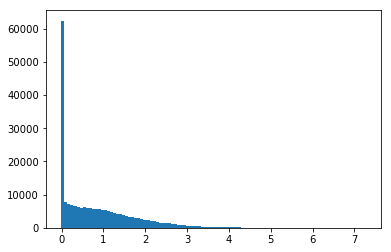

In [57]:
plt.hist(np.array(lst).mean(0).reshape([-1]),bins=100);

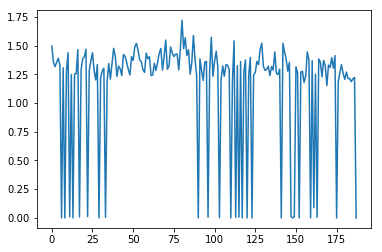

In [61]:
plt.plot(np.array(lst)[:,1,100]);

In [132]:
for j in range(1680,1690):
    print j,np.nanmean(rawy[:,:,j],dtype=np.float),np.nanmean(y[:,:,j],dtype=np.float)

1680 1.68076379258 0.767920783369
1681 1.6817010969 0.767110917695
1682 1.62592518996 0.723749680765
1683 1.73977632686 0.821946088589
1684 1.71138398698 0.813116099178
1685 1.76363572066 0.845206885747
1686 1.69733310583 0.787718954939
1687 1.70009994492 0.789479112634
1688 nan 0.0
1689 nan 0.0


/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [134]:
for j in range(1680,1693):
    u=train_test[:,:,j]
    print j,np.nanmean(np.isnan(u),dtype=np.float),np.nanmean(u,dtype=np.float)

1680 0.223005688615 1.43423049888
1681 0.224833614102 1.41957142134
1682 0.227142996655 1.43860958978
1683 0.226905442027 1.43298627665
1684 0.225485607559 1.44948979
1685 0.226241485388 1.44643070017
1686 0.227865426402 1.43595188906
1687 0.228550623795 1.38077216538
1688 0.215289313704 1.36422162938
1689 0.446378329549 1.24007197087
1690 0.470466564125 1.24309596858
1691 0.48700896018 1.26098642946
1692 0.509933714202 1.2424679345


In [155]:
df

col    1685    1686    1687    1688  \
0               store_mean_0-lag0-offset1     0.0     0.0     0.0     0.0   
1                   family_0-lag0-offset1  0.0002     0.0  0.0002  0.0002   
2                     city_0-lag0-offset1     0.0     0.0     0.0     0.0   
3               cluster_mv36-lag0-offset1     0.0     0.0     0.0     0.0   
4                  cluster_0-lag0-offset1     0.0     0.0     0.0     0.0   
5                  city_mv36-lag0-offset1     0.0     0.0     0.0     0.0   
6                item_mean_0-lag0-offset1  0.0827  0.0798  0.0824  0.0802   
7                    class_0-lag0-offset1  0.0071  0.0068  0.0073  0.0073   
8                     type_0-lag0-offset1     0.0     0.0     0.0     0.0   
9                  type_mv36-lag0-offset1     0.0     0.0     0.0     0.0   
10                state_mv36-lag0-offset1     0.0     0.0     0.0     0.0   
11                class_mv36-lag0-offset1  0.0083  0.0083  0.0083  0.0083   
12                   state_0-lag0-offset1     0.0     0.0     0.0     0.0   
13               family_mv36-lag0-offset1     0.0     0.0     0.0     0.0   
14                 holiday_0-lag0-offset0     0.0     0.0     0.0     0.0   
15                      d900-lag0-offset0     0.0     0.0     0.0     0.0   
16             onpromotion_0-lag0-offset0  0.5208  0.5359  0.5356  0.0485   
17                    wage_0-lag0-offset0     0.0     0.0     0.0     0.0   
18                       y_0-lag0-offset1  0.5249  0.5208  0.5359  0.5356   
19                       y_0-lag1-offset1  0.5276  0.5249  0.5208  0.5359   
20                       y_0-lag2-offset1  0.5549  0.5276  0.5249  0.5208   
21                       y_0-lag3-offset1  0.5438  0.5549  0.5276  0.5249   
22                       y_0-lag4-offset1  0.5431  0.5438  0.5549  0.5276   
23                       y_0-lag5-offset1  0.5308  0.5431  0.5438  0.5549   
24                       y_0-lag6-offset1  0.4994  0.5308  0.5431  0.5438   
25              sales_ma_224-lag0-offset1  0.5002  0.4986  0.4985  0.4984   
26               sales_ma_14-lag0-offset1  0.5092  0.5118  0.5132   0.516   
27               sales_ma_28-lag0-offset1  0.5029  0.5039  0.5041  0.5038   
28              sales_ma_112-lag0-offset1  0.4898  0.4901  0.4905  0.4904   
29                sales_ma_7-lag0-offset1  0.5092  0.5128  0.5133  0.5118   
30                sales_ma_3-lag0-offset1  0.5213  0.5104  0.5127  0.5173   
31               sales_ma_56-lag0-offset1  0.4955  0.4961  0.4962   0.496   
32   sales_week_season_ma_p7-lag6-offset1     0.0     0.0     0.0     0.0   
33   sales_week_season_ma_p4-lag6-offset1     0.0     0.0     0.0     0.0   
34  sales_week_season_ma_p13-lag6-offset1     0.0     0.0     0.0     0.0   
35   sales_week_season_ma_p2-lag6-offset1  0.4994  0.5308  0.5431  0.5438   
36   sales_week_season_ma_p3-lag6-offset1     0.0     0.0     0.0     0.0   

      1689    1690  
0      1.0     1.0  
1      1.0     1.0  
2      1.0     1.0  
3      0.0     0.0  
4      1.0     1.0  
5      0.0     0.0  
6      1.0     1.0  
7      1.0     1.0  
8      1.0     1.0  
9      0.0     0.0  
10     0.0     0.0  
11  0.0083  0.0083  
12     1.0     1.0  
13     0.0     0.0  
14     0.0     0.0  
15     0.0     0.0  
16  0.0485  0.0485  
17     0.0     0.0  
18     1.0     1.0  
19  0.5356     1.0  
20  0.5359  0.5356  
21  0.5208  0.5359  
22  0.5249  0.5208  
23  0.5276  0.5249  
24  0.5549  0.5276  
25  0.4996  0.5007  
26  0.5365  0.5599  
27  0.5124  0.5215  
28  0.4926  0.4947  
29  0.5472  0.5971  
30  0.6162     1.0  
31  0.5002  0.5043  
32     0.0     0.0  
33     0.0     0.0  
34     0.0     0.0  
35  0.5549  0.5276  
36     0.0     0.0

In [112]:
np.mean(y[:,0,1688],dtype=np.float),np.mean(y[:,0,1686],dtype=np.float),np.mean(y[:,0,1687],dtype=np.float)

(0.0, 0.13274016203703703, 0.14341001157407407)

(54, 4100) 0.874893


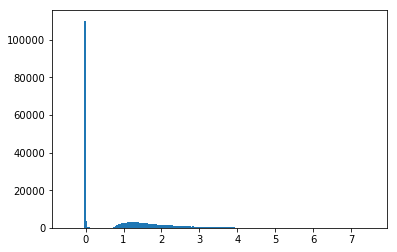

In [105]:
import cPickle as pickle
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1187]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape, np.nanmean(yy_pred3)
plt.hist(yy_pred3.reshape(-1),bins=200);

(54, 4100) 0.811659


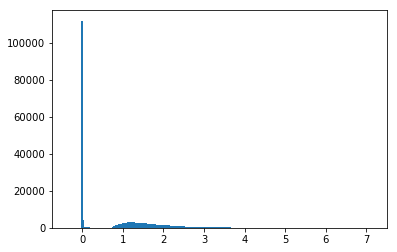

In [106]:
import cPickle as pickle
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1687]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape, np.nanmean(yy_pred3)
plt.hist(yy_pred3.reshape(-1),bins=200);

(54, 4100) 1.3095


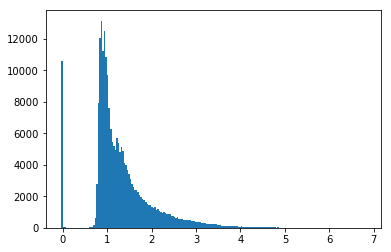

In [113]:
import cPickle as pickle
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1689]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape, np.nanmean(yy_pred3)
plt.hist(yy_pred3.reshape(-1),bins=200);

(54, 4100) 1.19451


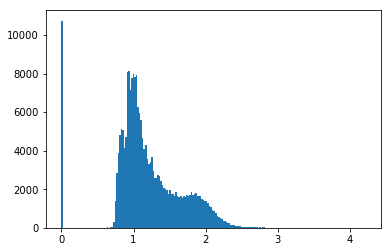

In [114]:
import cPickle as pickle
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1699]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape, np.nanmean(yy_pred3)
plt.hist(yy_pred3.reshape(-1),bins=200);

In [128]:
np.mean(isnan(train_test[:,:,1688]),dtype=np.float)

0.21528931370394785

In [129]:
np.mean(isnan(train_test[:,:,1687]),dtype=np.float)

0.22855062379452623

In [130]:
np.mean(isnan(train_test[:,:,1689]),dtype=np.float)

0.44637832954906126

(54, 4100) 1.35822


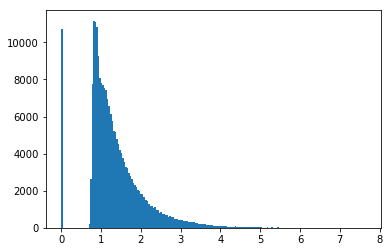

In [107]:
import cPickle as pickle
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1688]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape, np.nanmean(yy_pred3)
plt.hist(yy_pred3.reshape(-1),bins=200);
pickle.dump(yy_pred3,open(a.name+".alt.pred",'wb'))

In [52]:
c=np.arange(60).reshape([3,4,5])

In [53]:
(c.reshape([-1,5]).reshape([3,4,5])==c).all()

True